#### SVI data Analysis for Tennessee

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# imoporting SVI data for the entire US(county level) 
us_svi = gpd.read_file('./data/SVI data/SVI2020_US_county.gdb')

In [3]:
# include only the Washington DC, Virginia, Maryland, and West Virginia(county level)
filtered_svi_df = us_svi[us_svi['ST_ABBR'].isin(['TN'])]

In [4]:
# reset index
filtered_svi_df.reset_index(drop=True, inplace=True)

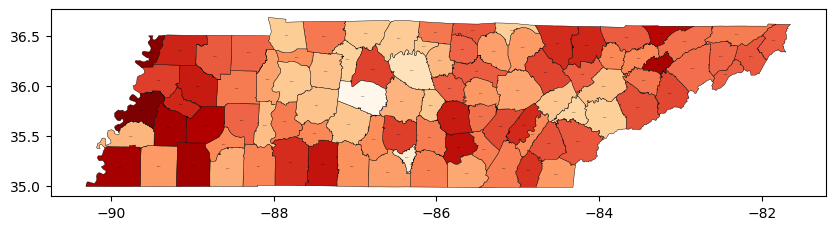

In [5]:
# Plot the data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
ax = filtered_svi_df.plot(figsize=(10, 10), column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black',linewidth=0.3)

for idx, row in filtered_svi_df.iterrows():
    centroid = row.geometry.centroid
    county_name = row.FIPS
    ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=0.5)

# Display the plot
plt.show()

In [6]:
# checking the data type of the FIPS column
print(type(filtered_svi_df['FIPS'][0]))

<class 'str'>


In [7]:
filtered_svi_df.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.2,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ..."
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.2,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ..."
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.2,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ..."


#### Overdose data (2020)
we need to combine Overdose data to the svi dataframe

In [14]:

# this contains mortality data for the Washington DC, Virginia, Maryland, and West Virginia(county level)
mortality_df = pd.read_csv('./data/Mortality data/Current Final Multiple Cause of Death Data/TennesseeDeaths_2018_2021.csv')

In [15]:
# rename county code column to FIPS
mortality_df.rename(columns={'County Code':'FIPS'}, inplace=True)

In [16]:
# convert FIPS column to string
mortality_df['FIPS'] = mortality_df['FIPS'].astype(str)

In [17]:
# filtering the mortality data for year 2020
mortality_df_2020 = mortality_df[mortality_df['Year']==2020]
mortality_df_2020.reset_index(drop=True, inplace=True)

In [18]:
mortality_df_2020.head(3)

,State,County,FIPS,Year,Year Code,Deaths,Population,Crude Rate
0,TN,"Anderson County, TN",47001,2020,2020,63,77558,81.2
1,TN,"Bedford County, TN",47003,2020,2020,16,50179,Unreliable
2,TN,"Benton County, TN",47005,2020,2020,Suppressed,16131,Suppressed


In [19]:
# Assuming filtered_df has the 'od_deaths' column
od_deaths_counts = mortality_df_2020['Deaths'].value_counts()

# Print the counts of each unique value in the 'od_deaths' column
print(od_deaths_counts)

Suppressed    35
14             6
10             5
17             4
13             3
0              3
16             3
12             3
38             2
33             2
23             2
63             2
41             2
22             2
94             1
31             1
48             1
24             1
71             1
461            1
56             1
133            1
43             1
66             1
34             1
11             1
35             1
350            1
20             1
29             1
18             1
141            1
21             1
448            1
79             1
Name: Deaths, dtype: int64


In [20]:
# Merge the dataframes on the 'FIPS' column(this will include all the 2020 data for the Washington DC, Virginia, Maryland, and West Virginia(county level))
merged_df_TN = pd.merge(filtered_svi_df, mortality_df_2020[['FIPS', 'Deaths']],
                     on='FIPS', how='left')

In [ ]:

# Rename the 'Provisional Drug Overdose Deaths' column to 'od_deaths'
# merged_df.rename(columns={'Provisional Drug Overdose Deaths': 'od_deaths'}, inplace=True)

# If there are NaN values in 'od_deaths' column, you can fill them with a default value, for example, 0
# merged_df['Deaths'].fillna(0, inplace=True)

# Now, merged_df contains the new column 'od_deaths' based on matching FIPS codes

In [21]:
merged_df_TN.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,Shape_Length,Shape_Area,geometry,Deaths
0,47,Tennessee,TN,47001,Anderson,47001,"Anderson County, Tennessee",337.203190,76513,0,...,0.1,0.1,2.4,0.6,0.3,0.2,1.832034,0.089394,"MULTIPOLYGON (((-84.44988 36.15105, -84.44823 ...",63
1,47,Tennessee,TN,47003,Bedford,47003,"Bedford County, Tennessee",473.638948,48937,0,...,0.0,0.1,2.4,0.6,0.7,0.6,1.833986,0.122174,"MULTIPOLYGON (((-86.66330 35.47122, -86.66292 ...",16
2,47,Tennessee,TN,47005,Benton,47005,"Benton County, Tennessee",394.306039,16133,0,...,0.0,0.2,1.0,1.0,0.0,0.2,1.910518,0.113043,"MULTIPOLYGON (((-88.22473 35.88639, -88.21660 ...",Suppressed


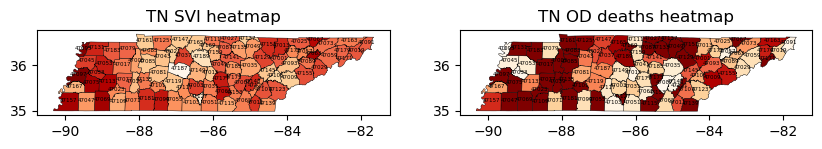

In [23]:
# Plot the data side by side using subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Plot for filtered_result (assuming filtered_result is your filtered dataframe)
ax1 = merged_df_TN.plot(ax=axes[0], column="RPL_THEMES", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax1.set_title('TN SVI heatmap')

# Plot for filtered_merged_df (assuming filtered_merged_df is your first filtered dataframe)
ax2 = merged_df_TN.plot(ax=axes[1], column="Deaths", legend=False, cmap='OrRd', edgecolor='black', linewidth=0.3)
ax2.set_title('TN OD deaths heatmap')

# Annotate the plots
for ax in [ax1, ax2]:
    for idx, row in merged_df_TN.iterrows():
        centroid = row.geometry.centroid
        county_name = row.FIPS
        ax.annotate(text=county_name, xy=(centroid.x, centroid.y), ha='center', fontsize=4)

# Display the plots
plt.show()

In [24]:
# make "Suppressed" values in the Deaths column to 5   
merged_df_TN['Deaths'].replace('Suppressed', 5, inplace=True)

In [25]:
# check the data type of the Deaths column
print(type(merged_df_TN['Deaths'][0]))

<class 'str'>


In [26]:
# convert Deaths column to float
merged_df_TN['Deaths'] = merged_df_TN['Deaths'].astype(float)

In [27]:
# create a new column 'od_deaths_per_1000' which is the ratio of 'od_deaths' to 'E_TOTPOP' and multiply by 1000
merged_df_TN['od_deaths_per_1000'] = (merged_df_TN['Deaths']/merged_df_TN['E_TOTPOP'])*1000

In [38]:
TN_svi_deaths = merged_df_TN

#### Now we need to select the socioeconmics variables and deaths data to create a prediction model to find most important variables
'E_TOTPOP','EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','EP_NOINT','EP_AFAM','EP_HISP','EP_ASIAN','EP_AIAN','EP_NHPI','EP_TWOMORE','EP_OTHERRACE','od_deaths_per_1000'

##### Socioeconomic variables
###### EP_POV150    Percentage of persons below 150% poverty estimate
###### EP_UNEMP    Unemployment Rate estimate
###### EP_HBURD    Percentage of housing cost-burdened occupied housing units with annual income less than $75,000 (30%+ of income spent on housing costs) estimate, 2016-2020 ACS estimate, 2016-2020 ACS
###### EP_NOHSDP   Percentage of persons with no high school diploma (age 25+) estimate
###### EP_UNINSUR  Percentage uninsured in the total civilian noninstitutionalized population estimate, 2016-2020 ACS

In [29]:
# socioeconomic variable into a list
socioeconomic_variable_names = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR']

In [30]:
# filter metro_svi_deaths dataframe to include only the socioeconomic variables and od_deaths_per_1000
tn_svi_deaths_socioeconomic = merged_df_TN[socioeconomic_variable_names + ['od_deaths_per_1000']]

In [31]:
tn_svi_deaths_socioeconomic.head()

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,od_deaths_per_1000
0,24.6,5.5,22.4,11.4,8.9,0.823389
1,24.6,4.4,24.7,16.5,11.3,0.326951
2,31.7,7.2,18.8,16.6,7.7,0.309924
3,27.8,7.5,13.5,21.6,16.4,0.000000
4,18.6,4.8,20.0,10.6,9.2,0.501364


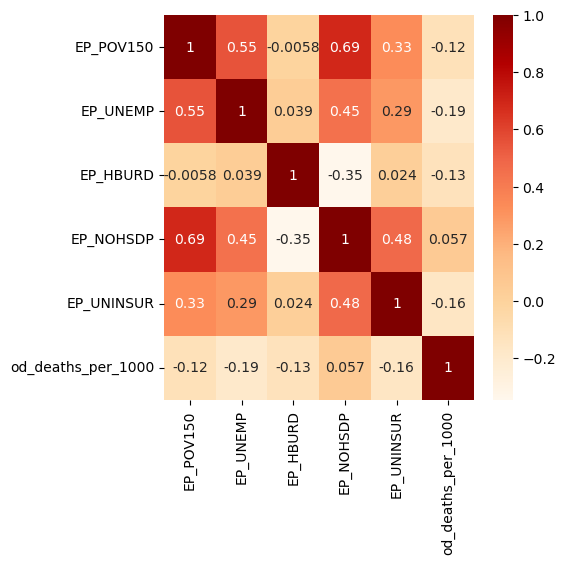

In [32]:
# create a correlation matrix
corr_matrix = tn_svi_deaths_socioeconomic.corr()

# plot the correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='OrRd')   
plt.show()

In [33]:
# split the metro_svi_deaths_socioeconomic data into train and test sets
from sklearn.model_selection import train_test_split

In [34]:
# create X and y
X = tn_svi_deaths_socioeconomic.drop('od_deaths_per_1000', axis=1)
y = tn_svi_deaths_socioeconomic['od_deaths_per_1000']

In [35]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### Feature Selection Methods

### Wrapper feature selection methods

#### 1. Forward Feature Selection


In [36]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','od_deaths_per_1000']

In [37]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

In [40]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
tnSviMultipleVariablesDf = TN_svi_deaths[selectedVariables]

In [41]:
# create X and y
X = tnSviMultipleVariablesDf.drop('od_deaths_per_1000', axis=1)
y = tnSviMultipleVariablesDf['od_deaths_per_1000']

In [42]:
#forward feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

In [43]:
# calling the linear regression model

lreg = LinearRegression()
sfs1 = SFS(lreg, k_features=4, forward=True, verbose=2, scoring='neg_mean_squared_error')

In [44]:
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2023-11-10 10:21:33] Features: 1/4 -- score: -0.04803833290148465[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2023-11-10 10:21:33] Features: 2/4 -- score: -0.0470245771963788[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.1s finished

[2023-11-10 10:21:33] Features: 3/4 -- score: -0.046290150117603505[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

In [45]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

['EP_NOHSDP', 'EP_MINRTY', 'EP_MUNIT', 'EP_GROUPQ']


In [46]:
# Which features?
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)


[3, 10, 11, 15]


#### 2. Backward Feature Selection


In [47]:
# calling the linear regression model

lreg = LinearRegression()
sfs2 = SFS(lreg, k_features=4, forward=False, verbose=2, scoring='neg_mean_squared_error')

In [48]:
sfs2 = sfs2.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2023-11-10 10:21:51] Features: 15/4 -- score: -0.05426348536257677[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2023-11-10 10:21:51] Features: 14/4 -- score: -0.05142970408496329[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.0s finished

[2023-11-10 10:21:51] Features: 13/4 -- score: -0.04986715784088202[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

In [49]:
feat_names = list(sfs2.k_feature_names_)
print(feat_names)

['EP_NOHSDP', 'EP_DISABL', 'EP_MUNIT', 'EP_GROUPQ']


### Embedded feature selection method

#### Lasso regression

In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [51]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [52]:
print("Shape of Train Features: {}".format(X_train.shape))
print("Shape of Test Features: {}".format(X_test.shape))
print("Shape of Train Target: {}".format(y_train.shape))
print("Shape of Test Target: {}".format(y_test.shape))

Shape of Train Features: (76, 16)
Shape of Test Features: (19, 16)
Shape of Train Target: (76,)
Shape of Test Target: (19,)


In [53]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

In [54]:
# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

In [55]:
# Initializing the Model
lasso = Lasso()

In [56]:
# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

Best Params {'alpha': 1e-05}


In [57]:
names=metroSviMultipleVariablesDf.drop("od_deaths_per_1000", axis=1).columns
print("Column Names: {}".format(names.values))

Column Names: ['EP_POV150' 'EP_UNEMP' 'EP_HBURD' 'EP_NOHSDP' 'EP_UNINSUR' 'EP_AGE65'
 'EP_AGE17' 'EP_DISABL' 'EP_SNGPNT' 'EP_LIMENG' 'EP_MINRTY' 'EP_MUNIT'
 'EP_MOBILE' 'EP_CROWD' 'EP_NOVEH' 'EP_GROUPQ']


In [58]:
#Using Lasso Regressor to plot the best features.

# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)

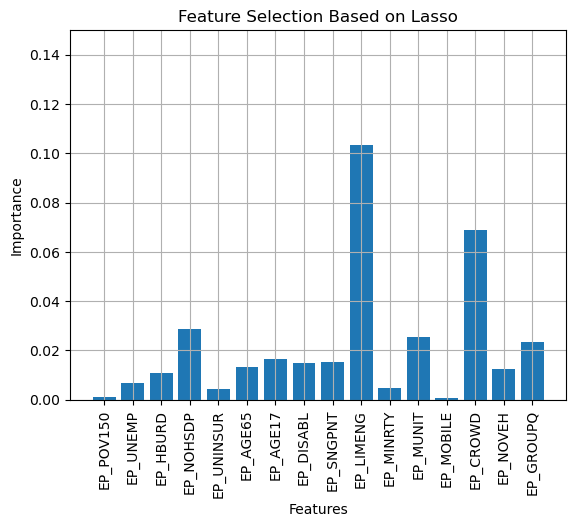

In [59]:
# plotting the Column Names and Importance of Columns. 
plt.bar(names, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [60]:
# Subsetting the features which has more than 0.001 importance.
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

Selected Feature Columns: ['EP_POV150' 'EP_UNEMP' 'EP_HBURD' 'EP_NOHSDP' 'EP_UNINSUR' 'EP_AGE65'
 'EP_AGE17' 'EP_DISABL' 'EP_SNGPNT' 'EP_LIMENG' 'EP_MINRTY' 'EP_MUNIT'
 'EP_CROWD' 'EP_NOVEH' 'EP_GROUPQ']


In [ ]:
#################

In [61]:
from sklearn.preprocessing import StandardScaler

In [62]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [63]:
scaler = StandardScaler().fit(X_train[selectedVariablesWithoutY]) 
X_train = scaler.transform(X_train[selectedVariablesWithoutY])

X_test = scaler.transform(X_test[selectedVariablesWithoutY])

In [64]:
X_train

array([[ 0.80565838, -1.19561853,  0.07747497, ..., -1.6030053 ,
         1.23172264, -0.43726787],
       [-0.44597769, -0.79041448, -0.38890902, ...,  0.29844134,
        -0.7275757 , -0.47243438],
       [ 0.1714961 ,  0.72910071,  3.4004609 , ...,  0.57007658,
         1.88482208, -0.2966018 ],
       ...,
       [ 1.08936255,  1.33690678, -0.00997203, ...,  0.02680611,
        -0.45545093, -0.57793393],
       [ 0.30500395, -0.53716195,  0.13577297, ..., -0.51646436,
        -0.61872579, -0.40210135],
       [-1.09682845, -1.09431751, -0.12656802, ...,  0.57007658,
         0.74189805, -0.5076009 ]])

In [65]:
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

In [66]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 0.0
R squared test set -35.79


In [67]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 0.04
MSE test set 0.09


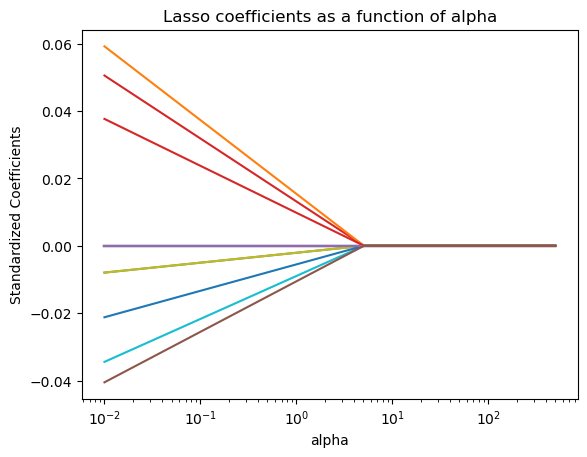

In [68]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

### Filter feature selection methods

In [69]:
tnSviMultipleVariablesDf

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,od_deaths_per_1000
0,24.6,5.5,22.4,11.4,8.9,19.9,21.1,20.8,5.7,0.8,11.4,8.3,13.0,1.9,4.8,1.7,0.823389
1,24.6,4.4,24.7,16.5,11.3,14.9,25.5,15.0,7.5,2.6,23.6,2.4,13.6,3.1,3.9,1.1,0.326951
2,31.7,7.2,18.8,16.6,7.7,23.9,19.8,27.6,5.3,0.0,4.6,0.5,29.4,0.6,6.0,1.2,0.309924
3,27.8,7.5,13.5,21.6,16.4,18.2,15.1,28.5,3.6,1.8,12.3,0.6,29.1,2.0,4.7,7.9,0.000000
4,18.6,4.8,20.0,10.6,9.2,20.2,20.2,13.8,4.5,0.8,9.4,4.5,11.7,2.1,3.4,1.5,0.501364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,28.6,6.0,16.1,19.0,12.4,19.2,17.4,19.9,6.5,0.3,10.5,1.2,26.8,2.9,6.7,12.3,0.300517
91,32.6,4.7,22.3,12.7,11.0,18.3,19.3,20.0,5.8,0.4,13.5,2.2,14.1,1.1,7.8,7.3,0.149804
92,29.4,4.9,21.8,18.9,11.1,20.2,21.9,17.6,6.1,0.1,6.9,1.0,16.9,1.4,4.2,1.5,0.627607
93,8.0,2.5,16.7,4.8,5.2,13.2,27.1,7.3,4.6,0.9,16.3,9.2,1.8,1.0,2.2,0.2,0.133402


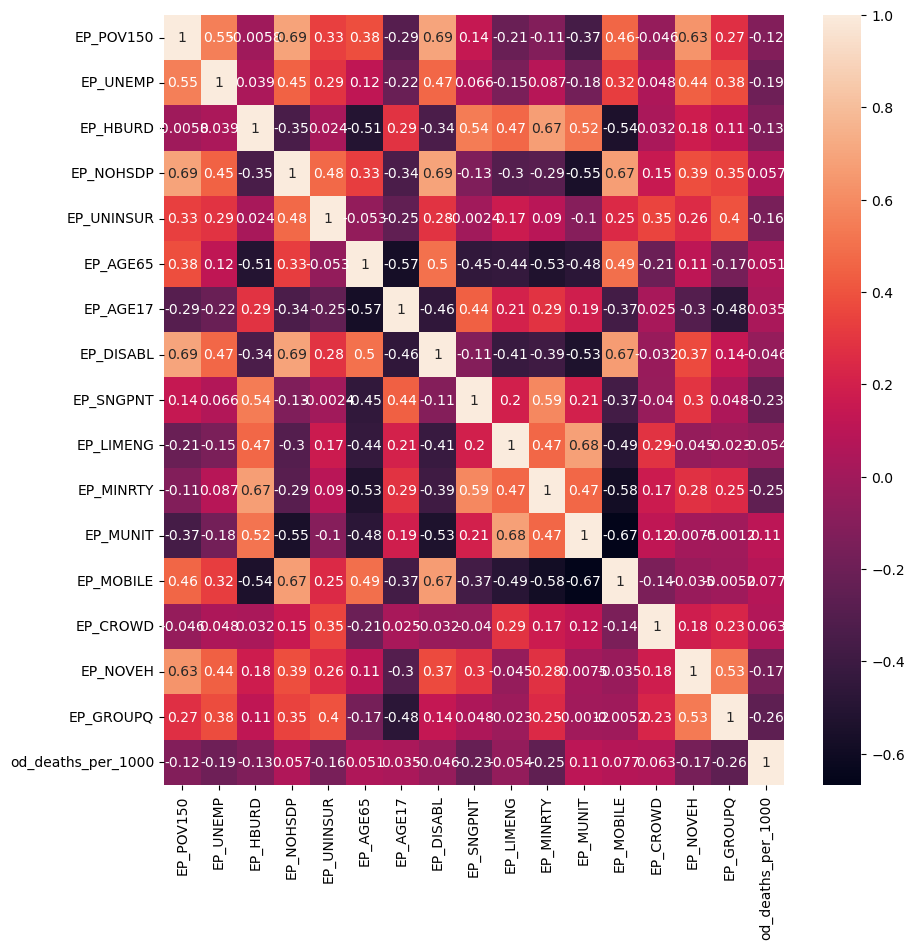

In [70]:
# measure the pearson correlation between the variables
from scipy.stats import pearsonr

# calculate Pearson's correlation matrix   
corr_matrix = tnSviMultipleVariablesDf.corr()

# plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

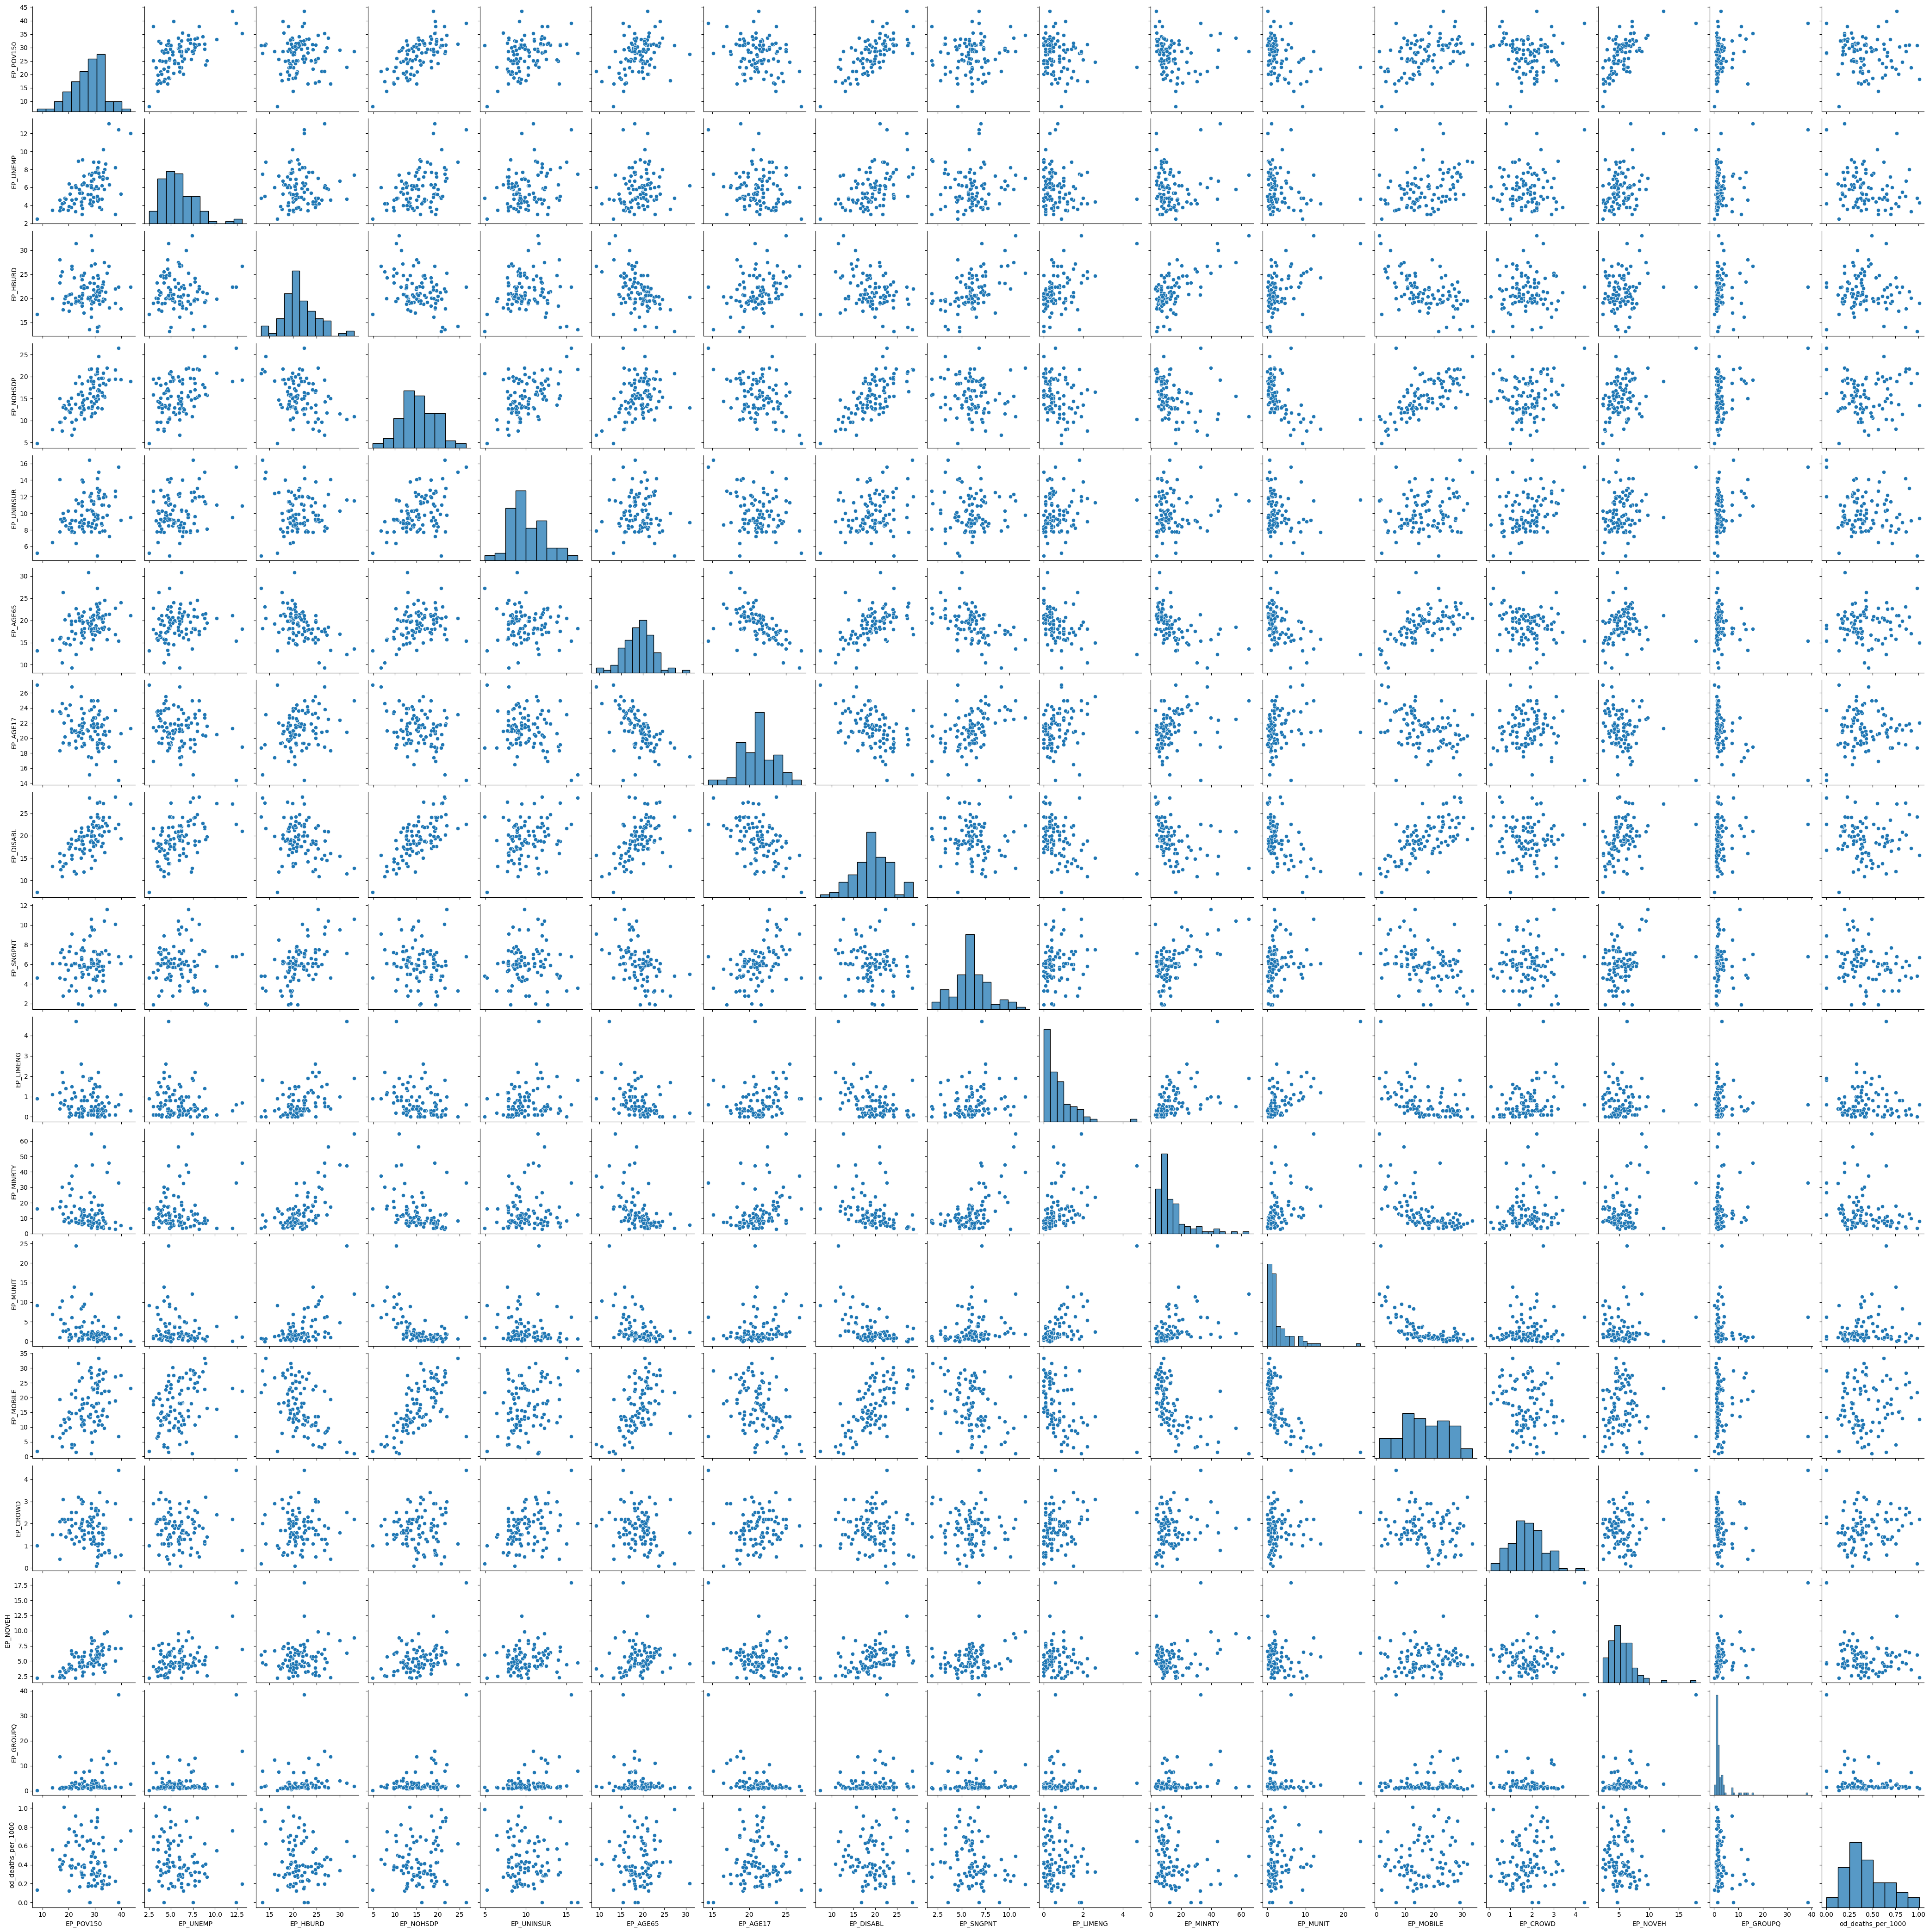

In [71]:
#Create scatter plots to visually inspect the relationship between each pair of variables
sns.pairplot(tnSviMultipleVariablesDf)
plt.show()


#### When nonlinear relations are expected we employ Spearman’s Rho	

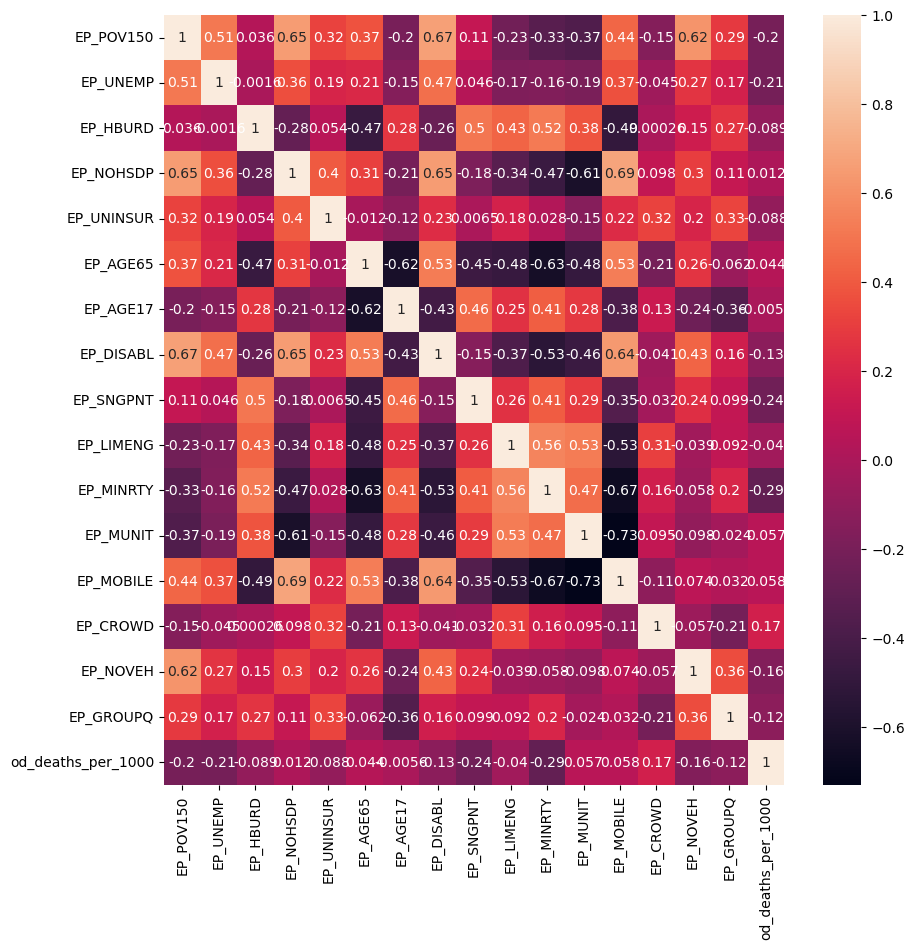

In [72]:
# calculate Spearman’s Rho	
from scipy.stats import spearmanr

# calculate spearman's correlation
coef, p = spearmanr(tnSviMultipleVariablesDf)
# print('Spearmans correlation coefficient: %.3f' % coef)

#plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(coef, annot=True, xticklabels=metroSviMultipleVariablesDf.columns, yticklabels=metroSviMultipleVariablesDf.columns)
plt.show()